In [75]:
!pip install tensorflow
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [76]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [77]:
datasets=tf.keras.utils.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [78]:
class_names = datasets.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [79]:
len(datasets)

68

In [80]:
for image_batch, label_batch in datasets.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 2 1 2 1 1 1 0 1 1 0 1 2 0 1 1 0 0 0 1 2 1 1 0 1 0 1 0 0 0 1]


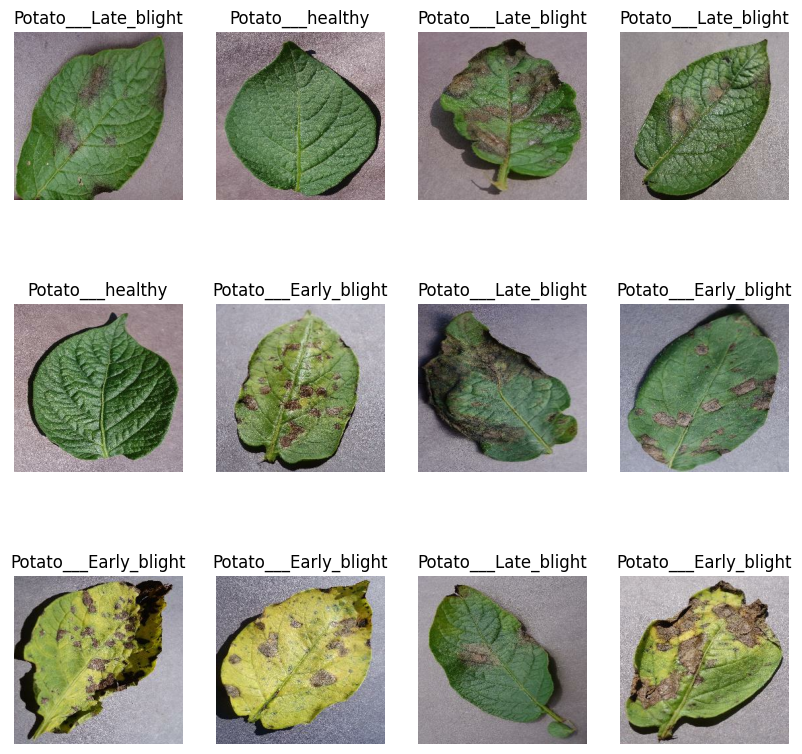

In [81]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [82]:
train_datasets = datasets.take(54)
len(train_datasets)

54

In [83]:
test_datasets = datasets.skip(54)
len(test_datasets)

14

In [84]:
val_datasets = test_datasets.take(6)
len(val_datasets)

6

In [85]:
test_datasets = test_datasets.skip(6)
len(test_datasets)

8

In [86]:
def get_datasets_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [87]:
train_ds, val_ds, test_ds= get_datasets_partitions_tf(datasets)

In [88]:
len(train_ds)

54

In [89]:
len(val_ds)

6

In [90]:
len(test_ds)

8

In [91]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [92]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [93]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [94]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape,),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

In [95]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [98]:
history= model.fit(
    train_datasets,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_datasets
)

Epoch 1/5
54/54 [==============================] - 47s 869ms/step - loss: 0.8136 - accuracy: 0.5909 - val_loss: 0.7896 - val_accuracy: 0.6667
Epoch 2/5
54/54 [==============================] - 50s 932ms/step - loss: 0.4609 - accuracy: 0.7940 - val_loss: 0.3051 - val_accuracy: 0.8646
Epoch 3/5
54/54 [==============================] - 51s 946ms/step - loss: 0.2869 - accuracy: 0.8854 - val_loss: 0.2161 - val_accuracy: 0.8958
Epoch 4/5
54/54 [==============================] - 52s 963ms/step - loss: 0.1599 - accuracy: 0.9352 - val_loss: 0.3803 - val_accuracy: 0.8594
Epoch 5/5
54/54 [==============================] - 53s 979ms/step - loss: 0.1096 - accuracy: 0.9630 - val_loss: 0.4904 - val_accuracy: 0.8333


In [99]:
scores= model.evaluate(test_datasets)
scores

8/8 [==============================] - 2s 159ms/step - loss: 0.4884 - accuracy: 0.8276


[0.488423615694046, 0.8275862336158752]

In [100]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [101]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
len(history.history)

4

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

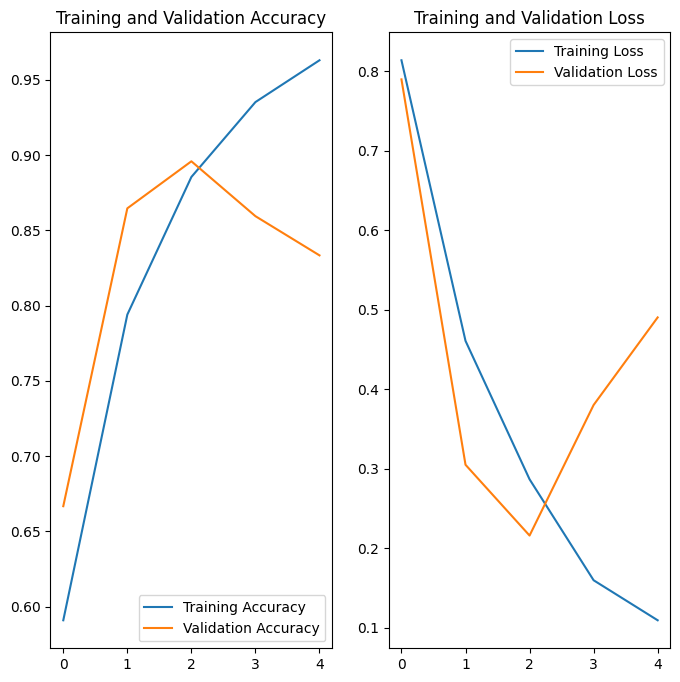

In [107]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 313ms/step
predicted label: Potato___Early_blight


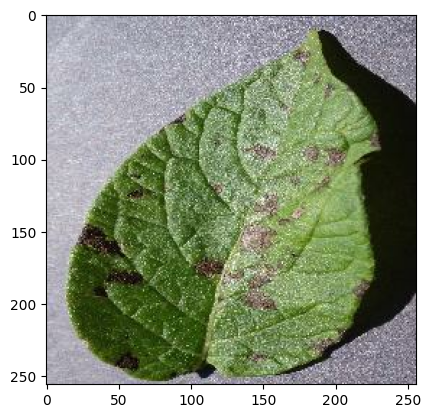

In [108]:
import numpy as np
for images_batch, labels_batch in test_datasets.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [109]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


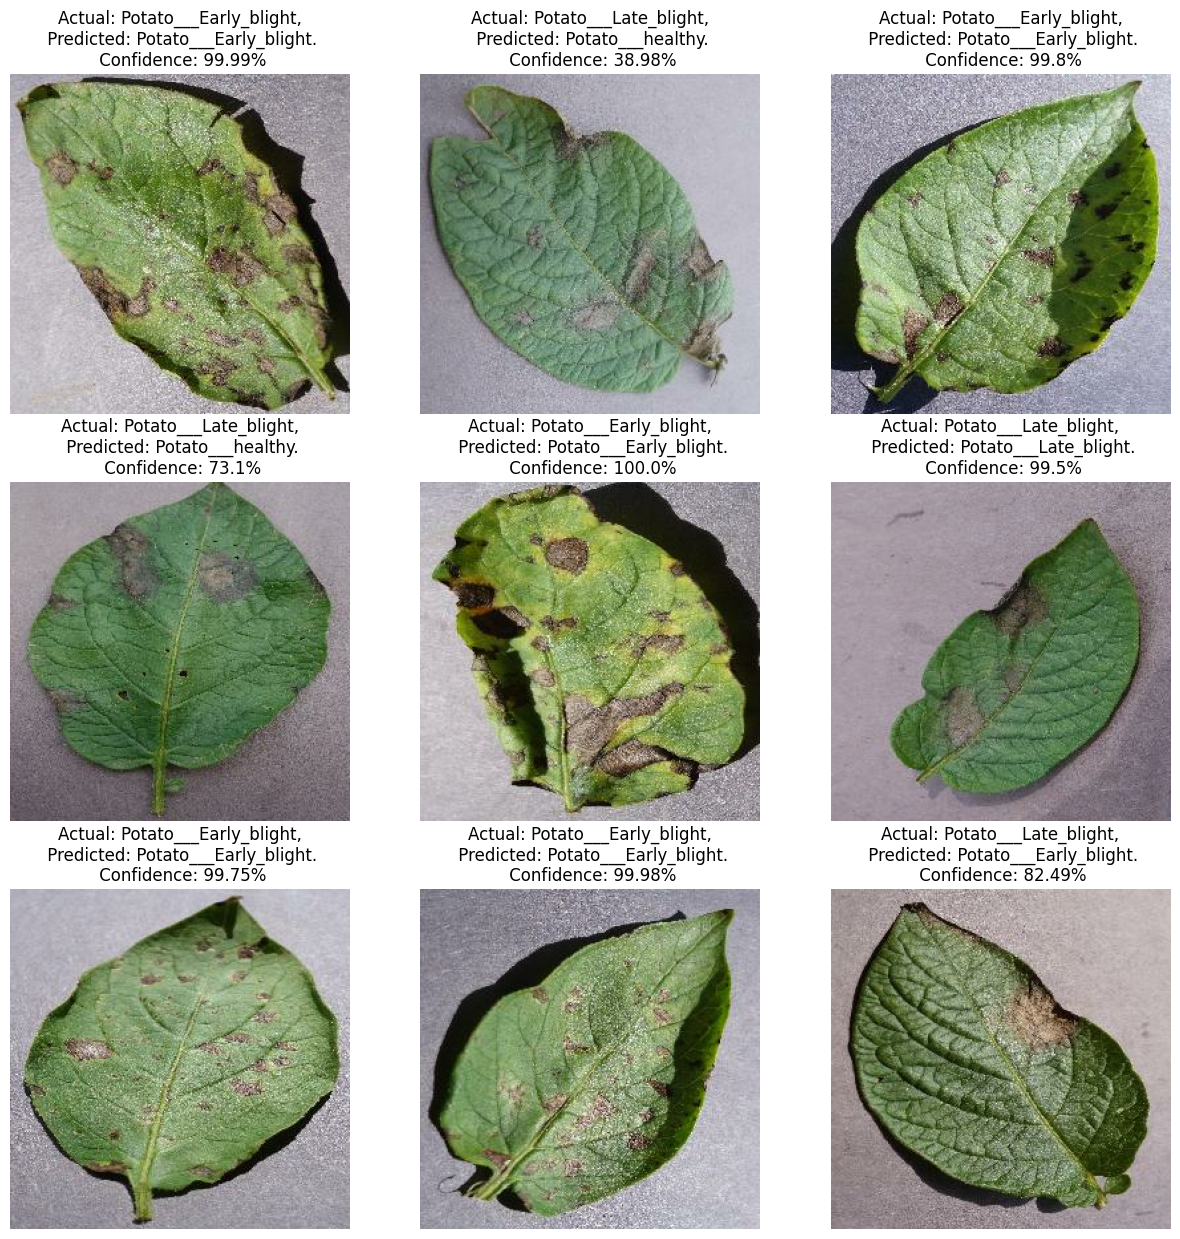

In [110]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [115]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [117]:
model.save("../potatoes.h5")